# 🎓 **Taller 4.5.1: Taller de Métodos de Clustering Jerarquico**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a ver cómo funcionan los algoritmos jerárquicos vistos en clase: el aglomerativo y el divisivo.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


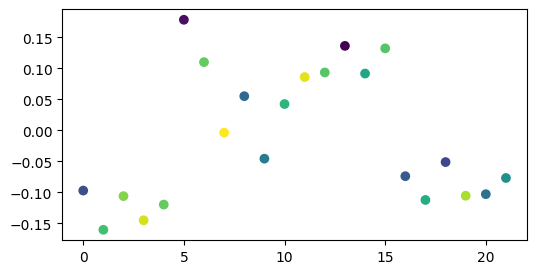

In [3]:
# Cargar dataset
D =cargar_dataset("dataset_reducido.xlsx")
Dx = D[:,0:2]
Dx = Dx[ np.random.choice(np.arange(Dx.shape[0]), Dx.shape[0], replace=False) ,:]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **1:Cree el Algoritmo de Clustering Aglomerativo**

Incluimos una serie de funciones que nos van a permitir visualizar los resultados.

In [4]:
def plot_particiones_grid(Dx, mParticiones, figsize=(15, 10)):

    n_partitions = mParticiones.shape[1] -1
    # Calcular distribución de subplots
    cols = min(4, n_partitions)  # Máximo 4 columnas
    rows = (n_partitions + cols - 1) // cols  # Redondeo hacia arriba

    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('Particiones Jerárquicas Aglomerativas', fontsize=16, fontweight='bold')

    # Obtener colormap una sola vez
    cmap = plt.colormaps['tab20']
    n_samples = Dx.shape[0]
    vals = np.linspace(0, 1, n_samples + 2)[1:-1]
    rgba = cmap(vals)

    for k in range(n_partitions):
        row = k // cols
        col = k % cols
        ax = axes[row, col]

        # Obtener etiquetas de cluster para esta partición
        labels = mParticiones[:, k]

        # Crear scatter plot
        scatter = ax.scatter(Dx[:, 0], Dx[:, 1],
                            c=rgba[labels],
                            s=50, alpha=0.8, edgecolors='w', linewidth=0.5)

        ax.set_title(f'K = {k+1} clusters', fontsize=11)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.grid(True, alpha=0.3, linestyle='--')

    # Ocultar ejes vacíos si hay menos subplots que celdas
    for k in range(n_partitions, rows * cols):
        row = k // cols
        col = k % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Ajustar para el título
    return fig, axes

In [5]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
  # Nueva sintaxis para obtener colormaps
    cmap = plt.colormaps['tab20']
    n_samples = Dx.shape[0]
    vals = np.linspace(0, 1, n_samples + 2)[1:-1]  # Más eficiente
    rgba = cmap(vals)
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(Dx[:, 0], Dx[:, 1],
               c=rgba[mParticiones[:, K-1]],  # Nota: no necesita el último ":"
               s=60, alpha=0.8)
    return fig, ax

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(15, 8))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()

**PASO 1:** calcular la matriz de distancias del dataset.

In [6]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

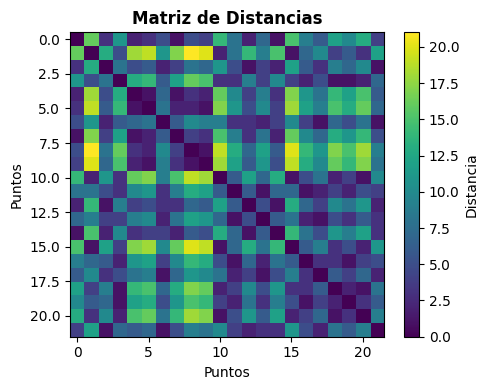

In [7]:
mD = matriz_distancias(Dx, distancia_euclidiana)

plt.figure(figsize=(5, 4))
plt.imshow(mD, cmap='viridis', vmin=mD.min(), vmax=mD.max(), aspect='auto')
plt.colorbar(label='Distancia')
plt.title('Matriz de Distancias', fontweight='bold')
plt.xlabel('Puntos')
plt.ylabel('Puntos')
plt.tight_layout()
plt.show()

**PASO 2**: union de clusters

Funciones para calcular el Criterio de Enlace

In [8]:
def Single_Linkage(mD, clust_actuales, particion):
    mDC = np.zeros((clust_actuales.size, clust_actuales.size))
    # Calculamos la distancia MINIMA entre todos los elementos del cluster `n1`y todos los del cluster `n2`
    for n1 in np.arange(clust_actuales.size):
        # Encontramos los índices de los elementos que pertenecen al cluster `n1`
        exC1 = np.where(particion==clust_actuales[n1])[0]
        # bucle para recorrer todos los clusters existentes para compararlos con el cluster `n1`
        for n2 in np.arange(clust_actuales.size):
            # Encontramos los índices de los elementos del cluster `n2`
            exC2 = np.where(particion==clust_actuales[n2])[0]
            # np._ix permite que podamos usar `exC1` y `exC2
            # como índices para coger todos los elementos de C1 y C2
            indices_C1_C2 = np.ix_(exC1, exC2)
            # Usando la matriz distancias `mD`, calculamos la distancia MINIMA
            # entre un cluster y el otro, usando sus indices
            mDC[n1,n2] = np.min(mD[indices_C1_C2])
    # Rellenamos la matriz diagonal con valores grandes (el máximo de la matriz
    # elevado al cuadrado) para evitar que se proponga la unión de un clúster consigo mismo.
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC

In [10]:
def CompleteLinkage(mD, clust_actuales, particion):
    mDC = np.zeros((clust_actuales.size, clust_actuales.size))
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            indices_C1_C2 = np.ix_(exC1, exC2)
            # Usando la matriz distancias `mD`, calculamos la distancia MAXIMA
            # entre un cluster y el otro, usando sus indices
            mDC[n1,n2] = np.max(mD[indices_C1_C2])
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC

In [12]:
def AverageLinkage(mD, clust_actuales, particion):
    mDC = np.zeros((clust_actuales.size, clust_actuales.size))
    for n1 in np.arange(clust_actuales.size):
        exC1 = np.where(particion==clust_actuales[n1])[0]
        for n2 in np.arange(clust_actuales.size):
            exC2 = np.where(particion==clust_actuales[n2])[0]
            indices_C1_C2 = np.ix_(exC1, exC2)
            #Usando la matriz distancias `mD`, calculamos la distancia MEDIA
            # entre un cluster y el otro, usando sus indices
            mDC[n1,n2] = np.mean(mD[indices_C1_C2])
    np.fill_diagonal(mDC, np.max(mDC)*2)
    return mDC

In [14]:
def clustering_aglomerativo(mD, criterio):
    mParticiones = np.zeros((mD.shape[0], mD.shape[0]), dtype = np.int8)
    # Rellenamos la última columna con valores del 0 al 21, ya que en este paso
    # cada elemento pertenecerá a un cluster distinto
    mParticiones[:,21] = np.arange(22)
    # Recorremos `mParticiones` de manera decreciente guardando los agrupamientos,
    # ya que sabemos que el número de uniones es exactamente de n-1
    for n in range(mParticiones.shape[1]-2, -1, -1):
        print(f'Paso número {n}')
        # Al empezar, asignamos el agrupamiento anterior al actual, ya que el
        # agrupamiento en el momento anterior (`n+1`) únicamente sufrirá alguna
        # modificación para juntar los dos clusters que mejor cumplan nuestro
        # criterio (min, max, mean).
        mParticiones[:,n] = mParticiones[:,n+1]
        # Obtenemos las "etiquetas" del agrupamiento actual (desde 0 hasta K)
        clust_actuales = np.unique(mParticiones[:,n])
        # Y calculamos la matriz distancia
        mDC = criterio(mD, clust_actuales, mParticiones[:,n])

        # Con la información de la matriz distancias somos capaces de ver qué
        # dos clusters son más parecidos. Necesitamos quedarnos no con el valor,
        # si no con el índice (el cual nos va a indicar qué dos clusters `i` y `j`
        # son los más parecidos). Para ello, usaremos la función `np.argmin`.
        ind_mDC_mejores_clusters = np.argmin(mDC)
        (cluster_i, cluster_j) = np.unravel_index(ind_mDC_mejores_clusters, mDC.shape)
        print(f'Índices de los clusters a unir (i, j): ({int(cluster_i)}, {int(cluster_j)})')

        # Vamos a asignar a uno de los clusters (`j`) la "etiqueta" del otro (`i`)
        etiqueta_cluster_i = clust_actuales[cluster_i]  # "etiqueta" del cluster `i`
        # Encontramos qué elementos pertenecen al cluster `j`
        elementos_pertenecientes_a_cluster_j = mParticiones[:, n] == clust_actuales[cluster_j]
        # Y les asignamos la etiqueta del cluster `i`
        mParticiones[elementos_pertenecientes_a_cluster_j, n] = etiqueta_cluster_i

        print(f'Cluster {cluster_i} y {cluster_j} asignados a etiqueta {etiqueta_cluster_i}')

    return mParticiones

Ahora ya podemos realizar el clustering jerárquico aglomerativo. Empezaremos por calcular la matriz de distancias, luego ejecutaremos el clustering con algun criterio de enlace, y mostraremos el dendrograma de los diferentes agrupamientos obtenidos.

In [15]:
# usando el criterio Single Linkage
mParticiones_min = clustering_aglomerativo(mD, Single_Linkage)

Paso número 20
Índices de los clusters a unir (i, j): (5, 9)
Cluster 5 y 9 asignados a etiqueta 5
Paso número 19
Índices de los clusters a unir (i, j): (6, 20)
Cluster 6 y 20 asignados a etiqueta 6
Paso número 18
Índices de los clusters a unir (i, j): (17, 19)
Cluster 17 y 19 asignados a etiqueta 18
Paso número 17
Índices de los clusters a unir (i, j): (5, 8)
Cluster 5 y 8 asignados a etiqueta 5
Paso número 16
Índices de los clusters a unir (i, j): (0, 7)
Cluster 0 y 7 asignados a etiqueta 0
Paso número 15
Índices de los clusters a unir (i, j): (7, 15)
Cluster 7 y 15 asignados a etiqueta 10
Paso número 14
Índices de los clusters a unir (i, j): (9, 11)
Cluster 9 y 11 asignados a etiqueta 12
Paso número 13
Índices de los clusters a unir (i, j): (2, 6)
Cluster 2 y 6 asignados a etiqueta 2
Paso número 12
Índices de los clusters a unir (i, j): (2, 12)
Cluster 2 y 12 asignados a etiqueta 2
Paso número 11
Índices de los clusters a unir (i, j): (2, 8)
Cluster 2 y 8 asignados a etiqueta 2
Paso 

In [ ]:
plot_dendrograma_de_mparticiones(mD, mParticiones_min)

El método de Clustering Aglomerativo puede ejecutarse utilizando distintos criterios de enlace. Cada uno de estos criterios define de manera diferente cómo se calcula la distancia entre clusters, lo que conduce a resultados de agrupamiento notablemente distintos.

In [16]:
# usando el criterio Complete Linkage
mParticiones_max = clustering_aglomerativo(mD, CompleteLinkage)

Paso número 20
Índices de los clusters a unir (i, j): (5, 9)
Cluster 5 y 9 asignados a etiqueta 5
Paso número 19
Índices de los clusters a unir (i, j): (6, 20)
Cluster 6 y 20 asignados a etiqueta 6
Paso número 18
Índices de los clusters a unir (i, j): (17, 19)
Cluster 17 y 19 asignados a etiqueta 18
Paso número 17
Índices de los clusters a unir (i, j): (0, 7)
Cluster 0 y 7 asignados a etiqueta 0
Paso número 16
Índices de los clusters a unir (i, j): (10, 12)
Cluster 10 y 12 asignados a etiqueta 12
Paso número 15
Índices de los clusters a unir (i, j): (8, 12)
Cluster 8 y 12 asignados a etiqueta 10
Paso número 14
Índices de los clusters a unir (i, j): (9, 12)
Cluster 9 y 12 asignados a etiqueta 11
Paso número 13
Índices de los clusters a unir (i, j): (3, 14)
Cluster 3 y 14 asignados a etiqueta 3
Paso número 12
Índices de los clusters a unir (i, j): (11, 12)
Cluster 11 y 12 asignados a etiqueta 13
Paso número 11
Índices de los clusters a unir (i, j): (2, 10)
Cluster 2 y 10 asignados a etiq

In [17]:
# usando el criterio  	Average Linkage
mParticiones_mean = clustering_aglomerativo(mD, AverageLinkage)

Paso número 20
Índices de los clusters a unir (i, j): (5, 9)
Cluster 5 y 9 asignados a etiqueta 5
Paso número 19
Índices de los clusters a unir (i, j): (6, 20)
Cluster 6 y 20 asignados a etiqueta 6
Paso número 18
Índices de los clusters a unir (i, j): (17, 19)
Cluster 17 y 19 asignados a etiqueta 18
Paso número 17
Índices de los clusters a unir (i, j): (0, 7)
Cluster 0 y 7 asignados a etiqueta 0
Paso número 16
Índices de los clusters a unir (i, j): (10, 12)
Cluster 10 y 12 asignados a etiqueta 12
Paso número 15
Índices de los clusters a unir (i, j): (8, 12)
Cluster 8 y 12 asignados a etiqueta 10
Paso número 14
Índices de los clusters a unir (i, j): (9, 12)
Cluster 9 y 12 asignados a etiqueta 11
Paso número 13
Índices de los clusters a unir (i, j): (3, 14)
Cluster 3 y 14 asignados a etiqueta 3
Paso número 12
Índices de los clusters a unir (i, j): (11, 12)
Cluster 11 y 12 asignados a etiqueta 13
Paso número 11
Índices de los clusters a unir (i, j): (5, 7)
Cluster 5 y 7 asignados a etique

La función plot_particiones_grid permite observar cómo son las diferentes particiones (niveles del clustering jerárquico) mostrando el dataset original con la asignación a clústeres descrita mediante colores:


(<Figure size 1500x1000 with 24 Axes>,
 array([[<Axes: title={'center': 'K = 1 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 2 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 3 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 4 clusters'}, xlabel='X1', ylabel='X2'>],
        [<Axes: title={'center': 'K = 5 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 6 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 7 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 8 clusters'}, xlabel='X1', ylabel='X2'>],
        [<Axes: title={'center': 'K = 9 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 10 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 11 clusters'}, xlabel='X1', ylabel='X2'>,
         <Axes: title={'center': 'K = 12 clusters'}, xlabel='X1', ylabel='X2'>],
       

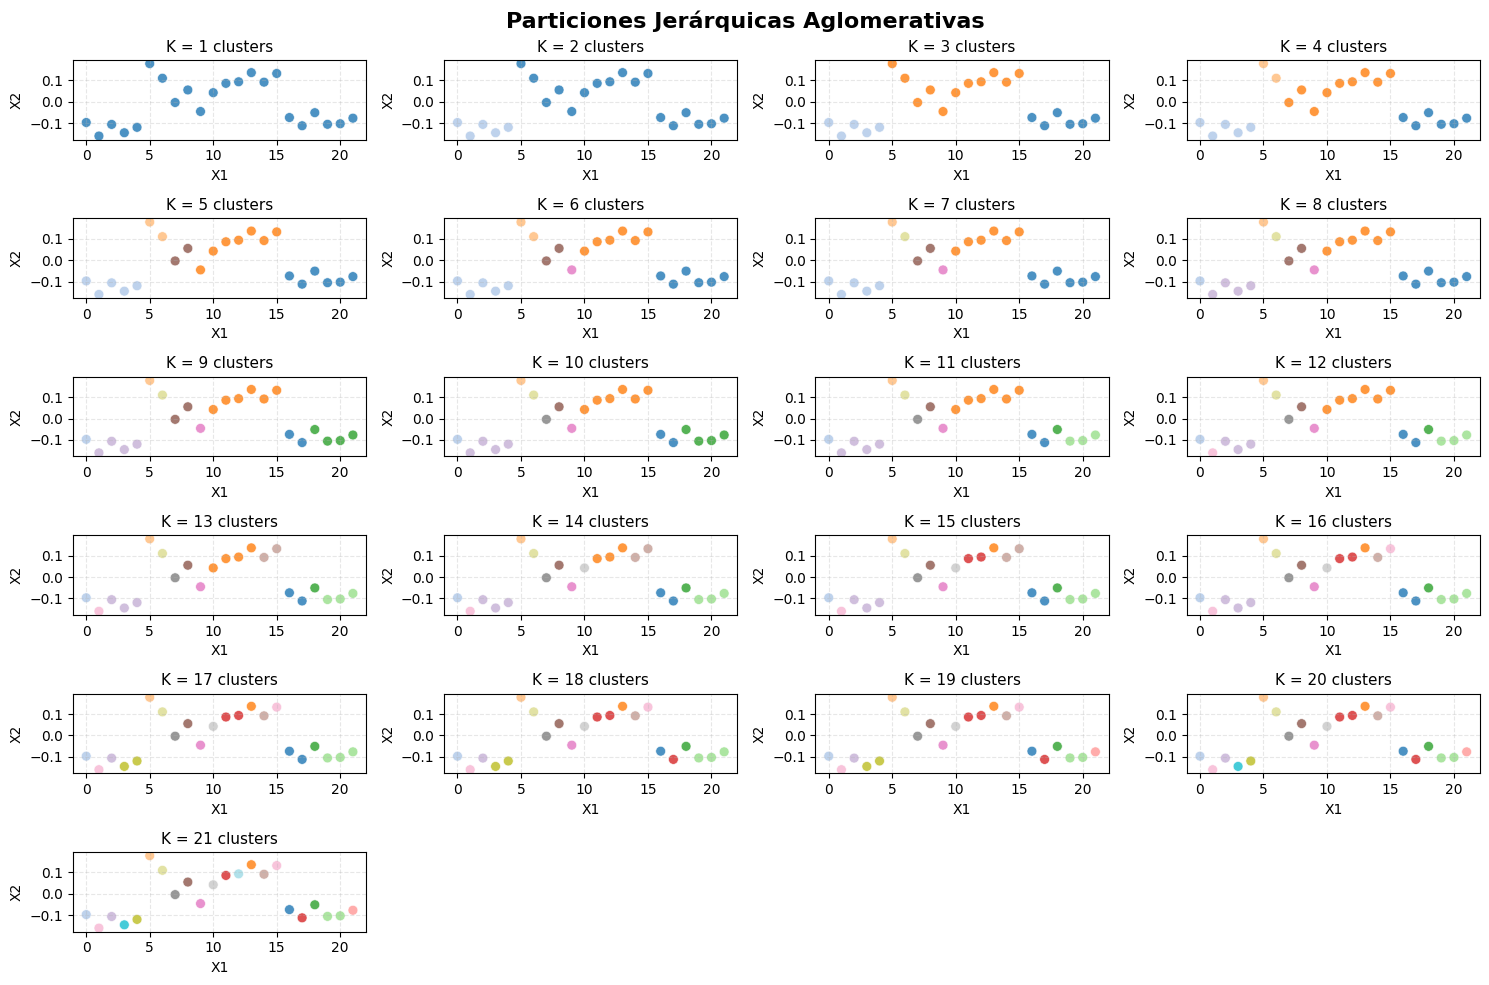

In [18]:
plot_particiones_grid(Dx, mParticiones_min)

El clustering jerárquico devuelve un espectro de agrupamientos. Muchas veces, es necesario seleccionar una única partición. Dada la matriz mParticiones, esto equivalente a quedarse con una de las columnas. Si queremos seleccionar una partición donde hayan K clústeres, debemos seleccionar la columna K-1.

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

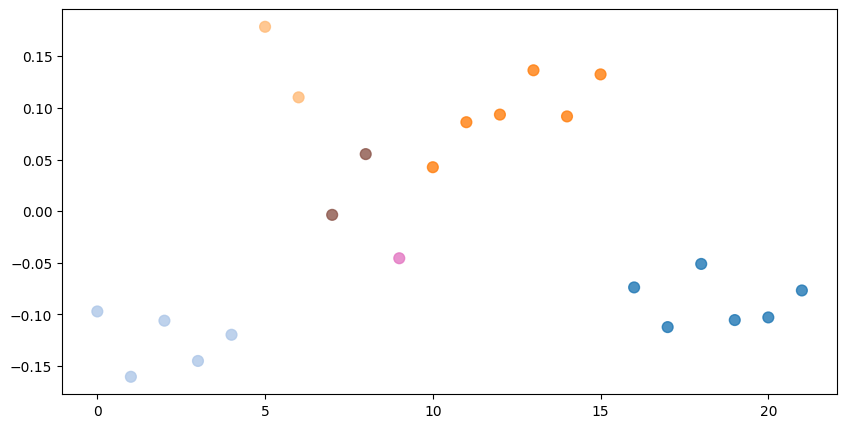

In [20]:
K =6
plot_particion_K(Dx, mParticiones_min,K)

Podemos calcular el valor de una métrica de evaluación cualquiera. En este caso, usamos las métricas de ancho de silueta y de Calinski Harabaz:

In [21]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
# Podemos elegir mParticiones_{min/max/mean}
mParticiones = mParticiones_min
K = 4
partToEval = mParticiones[:, mParticiones.shape[1] - K]

print('La medida de Silueta con K =',K,'es', silhouette_score(Dx, partToEval))
print('La medida de Calinski Harabaz con K =',K,'es', calinski_harabasz_score(Dx, partToEval))

La medida de Silueta con K = 4 es 0.002066768717593587
La medida de Calinski Harabaz con K = 4 es 98.22561770745634


Podríamos incluso dibujar de manera sencilla la figura del codo recorriendo todas las columnas:

Text(0, 0.5, 'Medida de Calinski Harabaz')

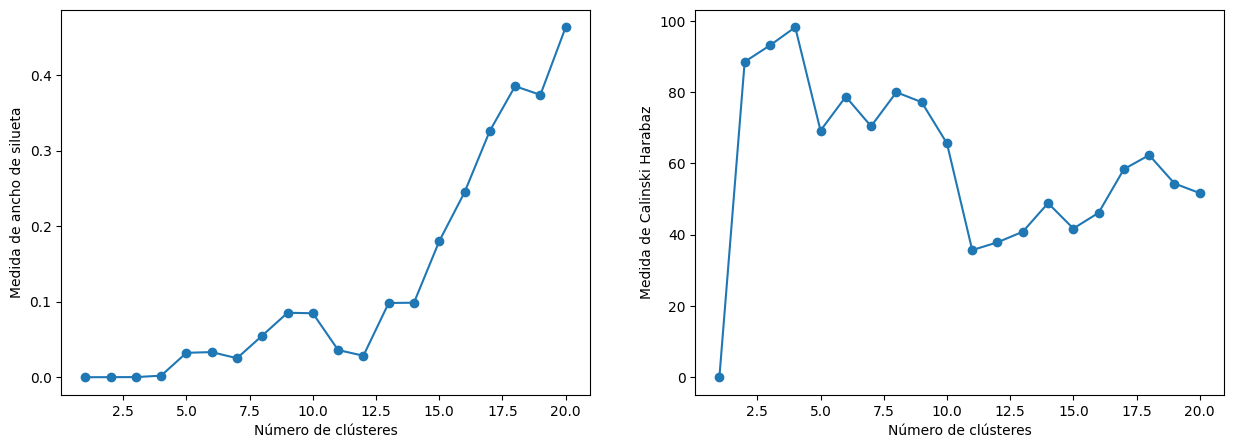

In [22]:
rsilueta = np.zeros(mParticiones.shape[1])
rch = np.zeros(mParticiones.shape[1])
for K in np.arange(1,mParticiones.shape[1]-1):
  # Get the partition for the current K
  partToEval = mParticiones[:, mParticiones.shape[1] - K]
  # Calculate silhouette score, but only if K > 1 (silhouette is not defined for K=1)
  if K > 1:
    rsilueta[K] = silhouette_score(Dx, partToEval)
  # Calculate Calinski-Harabasz score, but only if K > 1 (Calinski-Harabasz is not defined for K=1)
  if K > 1:
    rch[K] = calinski_harabasz_score(Dx, partToEval)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.arange(1,mParticiones.shape[1]-1), rsilueta[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot(np.arange(1,mParticiones.shape[1]-1), rch[np.arange(1,mParticiones.shape[1]-1)],
           linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de Calinski Harabaz")

<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering jerárquico aglomerativo. Están implementados (parámetro linkage) los criterios estudiados ('single', 'complete'y 'average') y muchos más.

Probablemente, la librería más completa para hacer clustering jerárquico aglomerativo es scipy. La función linkage es la encargada de hacer el agrupamiento jerárquico.

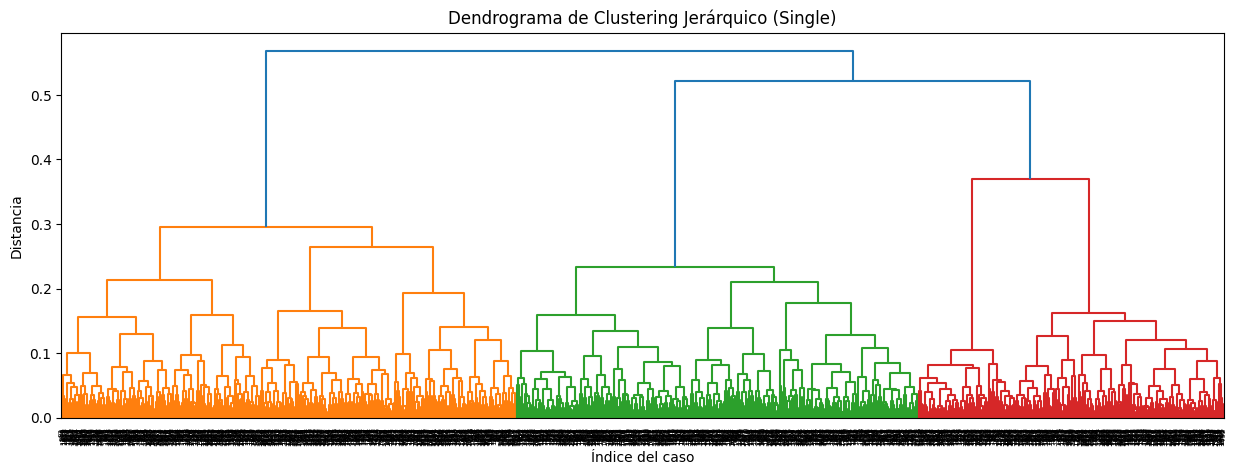

In [32]:
from sklearn.cluster import AgglomerativeClustering

modelo = AgglomerativeClustering(linkage="average")
#modelo = modelo.fit(Dx)

from scipy.cluster.hierarchy import linkage, fcluster, cut_tree

# pueden hacer pruebas comentando y descomentando
#modelo = linkage(Dx, 'single')
#modelo = linkage(Dx, 'complete')
modelo = linkage(Dx, 'average')

plt.figure(figsize=(15, 5))
plt.title('Dendrograma de Clustering Jerárquico (Single)')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo)
plt.show()

# 🎯 **EJ 2: Podemos hacer unas pruebas para ganar algunas intuiciones sobre cuál es la mejor estrategia según el tipo de datos...**



In [25]:
def plot_varios(Dx,Dy,K):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
    ax[0].set_title('Datos originales')

    modelo = linkage(Dx, 'single') ## P11 Complete su codigo aqui ##
    ax[1].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[1].set_title('Enlace Simple')

    modelo = linkage(Dx, 'complete') ## P12 Complete su codigo aqui ##
    ax[2].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[2].set_title('Enlace Completo')

    modelo = linkage(Dx, 'average') # P13 Complete su codigo aqui ##
    ax[3].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[3].set_title('Enlace Medio')

✅ Dataset cargado desde URL GitHub


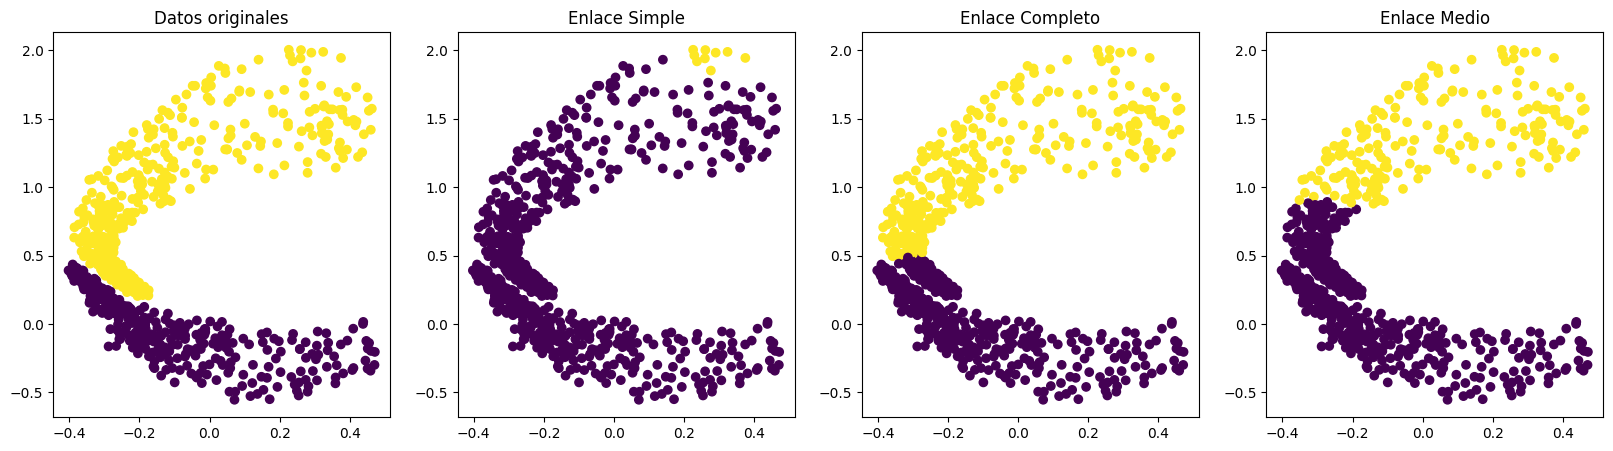

In [26]:
# Cargar dataset
D =cargar_dataset_csv("dataset_dos_remolinos.csv")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

# P14 Complete su codigo aqui ##
plot_varios(Dx,Dy,K=2)

✅ Dataset cargado desde URL GitHub


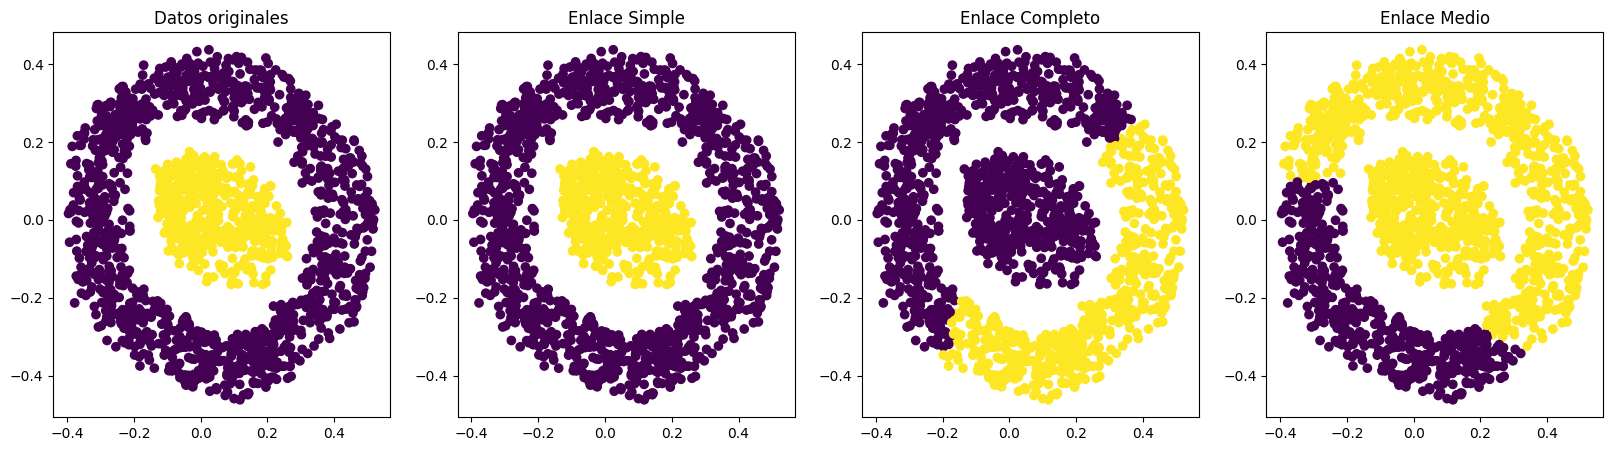

In [28]:
D =cargar_dataset_csv("dataset_circulos_concentricos.csv")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

# P15 Complete su codigo aqui ##
plot_varios(Dx,Dy,K=2)

✅ Dataset cargado desde URL GitHub


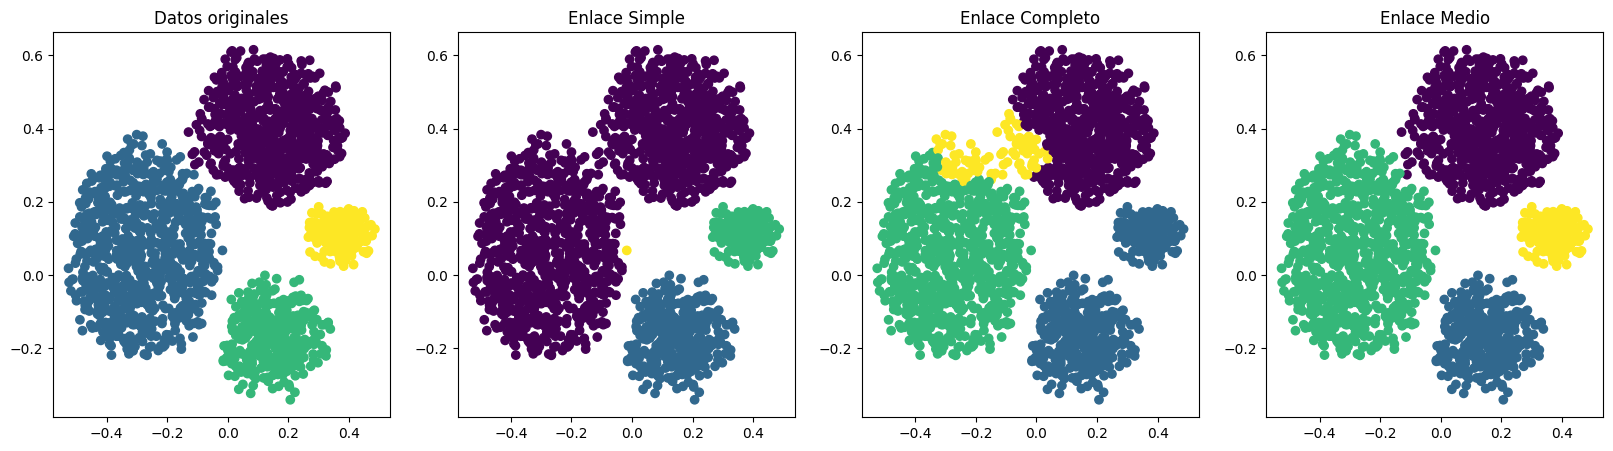

In [29]:
D =cargar_dataset_csv("dataset_cuatro_diferente_medida.csv")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

# P16 Complete su codigo aqui ##
plot_varios(Dx,Dy,K=4)

# 🚀 ¡TALLER FINALIZADO!"